# PART 2: Swaption Calibration

Group Members: 
1. Harshita Sachdev
2. Lu Tinjia
3. Rahul Sreeram
4. Srivatsa Sanjiv Mitragotri
5. Xie Zuoyu
6. Zhang Yonghan
7. Zhao Geping


In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import openpyxl


#### 1. Data Preparation

In [9]:
## 1. Data Preparation
def load_swaption_data(filepath):
    raw_data = pd.read_excel(filepath, sheet_name='Swaption', header=2)
    
    # Clean the data
    data = raw_data.dropna(subset=['Expiry'])
    data = data.set_index(['Expiry', 'Tenor'])
    strike_levels = ['-200bps', '-150bps', '-100bps', '-50bps', '-25bps', 
                    'ATM', '+25bps', '+50bps', '+100bps', '+150bps', '+200bps']
    data = data[strike_levels] / 100  # Convert from % to decimal
    
    return data


In [10]:
# Load the data
swaption_vols = load_swaption_data('IR Data.xlsx')

# Fix index type: convert '1Y' → 1
swaption_vols.index = swaption_vols.index.set_levels(
    [[int(e[:-1]) for e in swaption_vols.index.levels[0]],
     [int(t[:-1]) for t in swaption_vols.index.levels[1]]],
    level=[0, 1]
)

#### 2. Displaced-Diffusion Model

In [12]:
def black76_price(F, K, sigma, T, P, is_payer=True):
    d1 = (np.log(F/K) + 0.5*sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if is_payer:
        price = P * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        price = P * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    return price
def displaced_diffusion_vol(F, K, sigma, beta, T):
    alpha = (1-beta)*F
    d1 = (np.log((F+alpha)/(K+alpha)) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    return sigma*(F+alpha)*norm.pdf(d1)/(K+alpha)

def calibrate_displaced_diffusion(market_vols, strikes, F, T, beta_guess=0.5):
    def error_function(params):
        sigma, beta = params
        model_vols = [displaced_diffusion_vol(F, K, sigma, beta, T) for K in strikes]
        return np.sum((np.array(model_vols) - market_vols)**2)
    
    initial_guess = [market_vols[len(strikes)//2], 0.5]
    bounds = [(0.001, 2), (0.2, 0.8)]

    options = {'maxiter': 1000, 'ftol': 1e-6} # add optimizer option to improve the rate of successful
    result = minimize(error_function, initial_guess, bounds=bounds, method='L-BFGS-B', options=options)

    if result.success:
        return result.x
    else:
        print(f"Warning: DD calibration reached suboptimal solution for F={F}, T={T}")
        return result.x

#### 3. SABR Model

In [14]:
def sabr_vol(F, K, T, alpha, beta, rho, nu):
    epsilon = 1e-8  # Small number to avoid division by zero
    
    z = (nu/alpha) * (F*K)**((1-beta)/2) * np.log(F/K)
    z = np.where(np.isclose(F, K), epsilon, z)  # Handle ATM case
    
    xz = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho)/(1 - rho))
    xz = np.where(np.isclose(np.abs(rho), 1.0), z, xz)  # Handle |ρ| = 1
    
    Fmid = (F*K)**0.5
    prefactor = alpha / (Fmid**beta * (1 + ((1-beta)**2)/24 * np.log(F/K)**2 + 
                    ((1-beta)**4)/1920 * np.log(F/K)**4))
    
    # Compute the volatility expansion
    vol = prefactor * (1 + (((1-beta)**2)/24 * (alpha**2)/(Fmid**(2-2*beta)) + 
                      (rho*beta*nu*alpha)/(4*Fmid**(1-beta)) + 
                      (2-3*rho**2)/24 * nu**2) * T)
    
    # ATM case adjustment
    atm_vol = alpha / (F**beta) * (1 + (((1-beta)**2)/24 * (alpha**2)/(F**(2-2*beta)) + 
                          (rho*beta*nu*alpha)/(4*F**(1-beta)) + 
                          (2-3*rho**2)/24 * nu**2) * T)
    return np.where(np.isclose(F, K), atm_vol, vol * z/xz)

def calibrate_sabr(market_vols, strikes, F, T, beta_fixed=0.9):
    def error_function(params):
        alpha, rho, nu = params
        model_vols = [sabr_vol(F, K, T, alpha, beta_fixed, rho, nu) for K in strikes]
        return np.sum((np.array(model_vols) - market_vols)**2)
    
    # Initial guesses
    atm_vol = market_vols[len(strikes)//2]  # ATM vol approximation
    alpha_guess = atm_vol * (F**(beta_fixed))
    rho_guess = -0.3 if (strikes[-1] < F) else 0.3
    nu_guess = 0.5
    
    bounds = [
        (0.001, atm_vol*3),    # alpha
        (-0.99, 0.99),         # rho
        (0.1, 1.5)             # nu(Avoid approaching 0)
    ]
    
    result = minimize(error_function, [alpha_guess, rho_guess, nu_guess], bounds=bounds, method='L-BFGS-B')
    
    if not result.success:
        print(f"SABR calibration warning: {result.message} for F={F}, T={T}")
    return result.x


#### 4. Calibration Process

In [16]:
def perform_calibrations(swaption_vols, forward_rates, annuities):
    # Verify data integrity
    missing_pairs = []
    for expiry, tenor in swaption_vols.index:
        if (expiry, tenor) not in forward_rates.index:
            missing_pairs.append(f"Forward rate missing for {expiry}x{tenor}")
        if (expiry, tenor) not in annuities.index:
            missing_pairs.append(f"Annuity missing for {expiry}x{tenor}")
    
    if missing_pairs:
        raise ValueError("Missing data detected:\n" + "\n".join(missing_pairs))
    
    # Initialize results containers
    dd_results = []
    sabr_results = []
    
    strikes_bps = [-200, -150, -100, -50, -25, 0, +25, +50, +100, +150, +200]
    
    for expiry, tenor in swaption_vols.index:
        T = expiry  # Assuming expiry is in years
        F = forward_rates.loc[(expiry, tenor)]
        P = annuities.loc[(expiry, tenor)]
        
        # Get market vols for this expiry/tenor
        market_vols = swaption_vols.loc[(expiry, tenor)].values
        strikes = [F + s/10000 for s in strikes_bps]  # Convert bps to decimals
        
        # Displaced-diffusion calibration
        try:
            sigma, beta= calibrate_displaced_diffusion(market_vols, strikes, F, T)
            dd_results.append({
                'Expiry': expiry,
                'Tenor': tenor,
                'Sigma': sigma,
                'Beta': beta
            })
        except Exception as e:
            print(f"Failed DD calibration for {expiry}x{tenor}: {str(e)}")
            dd_results.append({
                'Expiry': expiry,
                'Tenor': tenor,
                'Sigma': np.nan,
                'Beta': np.nan
            })
        
        # SABR calibration (with β=0.9)
        try:
            alpha, rho, nu = calibrate_sabr(market_vols, strikes, F, T, beta_fixed=0.9)
            sabr_results.append({
                'Expiry': expiry,
                'Tenor': tenor,
                'Alpha': alpha,
                'Rho': rho,
                'Nu': nu
            })
        except Exception as e:
            print(f"Failed SABR calibration for {expiry}x{tenor}: {str(e)}")
            sabr_results.append({
                'Expiry': expiry,
                'Tenor': tenor,
                'Alpha': np.nan,
                'Rho': np.nan,
                'Nu': np.nan
            })
    
    # Convert to DataFrames
    dd_df = pd.DataFrame(dd_results).set_index(['Expiry', 'Tenor'])
    sabr_df = pd.DataFrame(sabr_results).set_index(['Expiry', 'Tenor'])
    
    return dd_df, sabr_df

#### 5. Interpolation Function

In [18]:
def interpolate_parameters(expiry, tenor, params_df):
    # Check whether the parameter exists
    if (expiry, tenor) in params_df.index:
        return params_df.loc[(expiry, tenor)]
    
    # Get the availability period and check
    expiries = sorted(params_df.index.get_level_values('Expiry').unique())
    if not expiries:
        raise ValueError("No calibration data available")
    
    # check the Inspection period
    if expiry < expiries[0] or expiry > expiries[-1]:
        raise ValueError(f"Cannot interpolate: expiry {expiry} outside range [{expiries[0]}, {expiries[-1]}]")
    
    # Get all unique expiries
    expiries = sorted(params_df.index.get_level_values('Expiry').unique())
    if expiry in expiries:
        return params_df.loc[(expiry, tenor)]
    
    # Find bracketing expiries
    lower = max([e for e in expiries if e < expiry], default=None)
    upper = min([e for e in expiries if e > expiry], default=None)

    # Linear interpolation weights
    weight = (expiry - lower) / (upper - lower)
    lower_params = params_df.loc[(lower, tenor)]
    upper_params = params_df.loc[(upper, tenor)]
    return lower_params * (1 - weight) + upper_params * weight


#### 6. Swaption Pricing

In [20]:
def price_swaptions(expiry, tenor, strikes, model_type, params, forward_rates, annuities, is_payer=True):
    T = expiry
    F = forward_rates.loc[(expiry, tenor)]
    P = annuities.loc[(expiry, tenor)]
    
    prices = []
    for K in strikes:
        if model_type == 'dd':
            sigma, beta = params
            vol = displaced_diffusion_vol(F, K, sigma, beta, T)
        elif model_type == 'sabr':
            alpha, rho, nu = params
            vol = sabr_vol(F, K, T, alpha, 0.9, rho, nu)  # β fixed at 0.9
        price = black76_price(F, K, vol, T, P, is_payer)
        prices.append(price)
    return prices


### Main Execution：

In [22]:
forward_rates = pd.DataFrame({
    'Expiry': [1, 1, 1, 1, 1, 2, 5, 5, 5, 5, 5, 8, 10, 10, 10, 10, 10],
    'Tenor':  [1, 2, 3, 5, 10, 10, 1, 2, 3, 5, 10, 10, 1, 2, 3, 5, 10],
    'Rate':   [0.028, 0.03, 0.0315, 0.033, 0.037, 0.036,  # 2×10
               0.033, 0.035, 0.036, 0.038, 0.04,
               0.038,                                     # 8×10
               0.037, 0.039, 0.04, 0.042, 0.045]
}).set_index(['Expiry', 'Tenor'])['Rate']

annuities = pd.DataFrame({
    'Expiry': [1, 1, 1, 1, 1, 2, 5, 5, 5, 5, 5, 8, 10, 10, 10, 10, 10],
    'Tenor':  [1, 2, 3, 5, 10, 10, 1, 2, 3, 5, 10, 10, 1, 2, 3, 5, 10],
    'Annuity':[0.98, 1.95, 2.9, 4.8, 9.5, 9.0,
               4.75, 9.4, 14, 23, 45,
               42,
               9.3, 18.5, 27.5, 45.5, 89]
}).set_index(['Expiry', 'Tenor'])['Annuity']

In [23]:
# 1. Perform calibrations
dd_params, sabr_params = perform_calibrations(swaption_vols, forward_rates, annuities)
    
# 2. Generate required tables
print("Displaced-Diffusion Parameters:")
print(dd_params.unstack())
   
print("\nSABR Parameters (β=0.9):")
print(sabr_params.unstack())

# Create formatted parameter tables for display
sigma_table = dd_params['Sigma'].unstack()
beta_table = dd_params['Beta'].unstack()

alpha_table = sabr_params['Alpha'].unstack()
rho_table   = sabr_params['Rho'].unstack()
nu_table    = sabr_params['Nu'].unstack()


# 3. Price the required swaptions
# 2y×10y payer swaptions
strikes = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
    
# Get interpolated parameters for 2Y expiry, 10Y tenor
dd_2y10y = interpolate_parameters(2, 10, dd_params)
sabr_2y10y = interpolate_parameters(2, 10, sabr_params)
    
# Price with both models
dd_prices = price_swaptions(2, 10, strikes, 'dd', dd_2y10y, forward_rates, annuities)
sabr_prices = price_swaptions(2, 10, strikes, 'sabr', sabr_2y10y, forward_rates, annuities)
    
print("\n2yx10y Payer Swaption Prices:")
print(pd.DataFrame({
    'Strike': strikes,
    'DD Price': dd_prices,
    'SABR Price': sabr_prices
}))
    
# 8y×10y receiver swaptions
receiver_strikes = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
    
# get Interpolating parameter
dd_8y10y = interpolate_parameters(8, 10, dd_params)
sabr_8y10y = interpolate_parameters(8, 10, sabr_params)

# use is_payer=False call
dd_receiver_prices = price_swaptions(8, 10, receiver_strikes, 'dd', dd_8y10y, forward_rates, annuities, is_payer=False)
sabr_receiver_prices = price_swaptions(8, 10, receiver_strikes, 'sabr', sabr_8y10y, forward_rates, annuities, is_payer=False)

print("\n8yx10y Receiver Swaption Prices:")
print(pd.DataFrame({
    'Strike': receiver_strikes,
    'DD Price': dd_receiver_prices,
    'SABR Price': sabr_receiver_prices
    }))

Displaced-Diffusion Parameters:
           Sigma                                         Beta            \
Tenor         1         2         3         5         10   1    2    3    
Expiry                                                                    
1       2.000000  2.000000  2.000000  0.933329  0.775854  0.8  0.8  0.8   
5       0.920118  0.912598  0.910372  0.908014  0.905637  0.8  0.8  0.8   
10      0.642497  0.640735  0.639940  0.638878  0.637593  0.8  0.8  0.8   

                       
Tenor         5    10  
Expiry                 
1       0.466285  0.2  
5       0.800000  0.8  
10      0.800000  0.8  

SABR Parameters (β=0.9):
           Alpha                                               Rho            \
Tenor         1         2         3         5         10        1         2    
Expiry                                                                         
1       0.006783  0.010220  0.011189  0.009558  0.010366  0.292836  0.291423   
5       0.009945  0.011831 

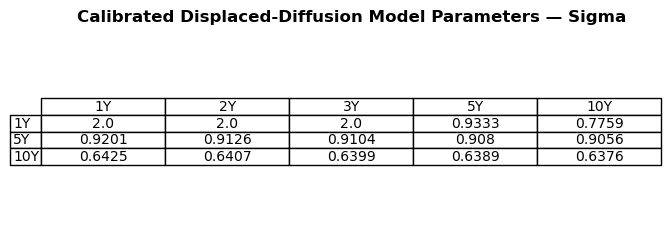

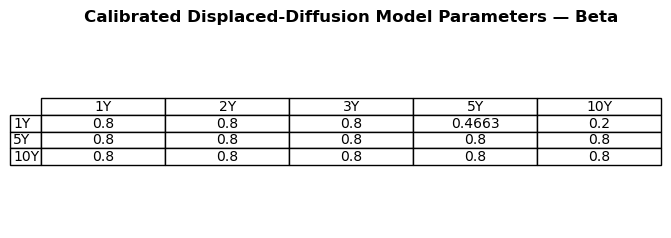

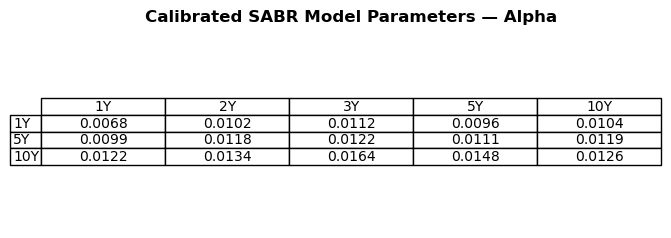

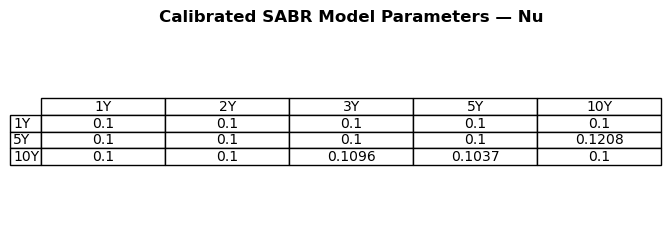

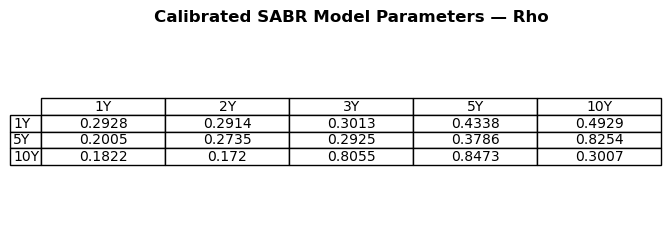

In [24]:
def plot_parameter_table(df, title):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.round(4).values,
                     rowLabels=[f"{i}Y" for i in df.index],
                     colLabels=[f"{i}Y" for i in df.columns],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    ax.set_title(title, fontweight='bold', fontsize=12, pad=10)
    plt.show()

plot_parameter_table(sigma_table, "Calibrated Displaced-Diffusion Model Parameters — Sigma")
plot_parameter_table(beta_table,  "Calibrated Displaced-Diffusion Model Parameters — Beta")
plot_parameter_table(alpha_table, "Calibrated SABR Model Parameters — Alpha")
plot_parameter_table(nu_table,    "Calibrated SABR Model Parameters — Nu")
plot_parameter_table(rho_table,   "Calibrated SABR Model Parameters — Rho")

In [25]:
payer_results = pd.DataFrame({
    'Strike': strikes,
    'DD Price': dd_prices,
    'SABR Price': sabr_prices
})
payer_results

,Strike,DD Price,SABR Price
0,0.01,0.234055,0.249250
1,0.02,0.148266,0.154291
2,0.03,0.079510,0.068007
3,0.04,0.034743,0.032701
4,0.05,0.011663,0.024296
5,0.06,0.002785,0.018623
6,0.07,0.000431,0.014343
7,0.08,0.000039,0.011068


In [26]:
receiver_results = pd.DataFrame({
    'Strike': receiver_strikes,
    'DD Price': dd_receiver_prices,
    'SABR Price': sabr_receiver_prices
})

receiver_results

,Strike,DD Price,SABR Price
0,0.01,0.006000,0.298184
1,0.02,0.049872,0.276137
2,0.03,0.158419,0.251004
3,0.04,0.349521,0.496876
4,0.05,0.625264,0.928791
5,0.06,0.969752,1.348741
6,0.07,1.357862,1.758276
7,0.08,1.767281,2.162483


In [27]:
def plot_calibration_results(expiry, tenor, model_type, params, swaption_vols, forward_rates):
    try:
        # Verify input data integrity
        if (expiry, tenor) not in swaption_vols.index:
            raise ValueError(f"Volatility data{expiry}Y×{tenor} for Y is missing")
        if (expiry, tenor) not in forward_rates.index:
            raise ValueError(f"forward interest rate{expiry}Y×{tenor}for Y is missing")
        
        # Obtain market data
        market_vols = swaption_vols.loc[(expiry, tenor)].values
        F = forward_rates.loc[(expiry, tenor)]
        
        # 3. define the range of the strike（ In unit of bps）
        strikes_bps = [-200, -150, -100, -50, -25, 0, +25, +50, +100, +150, +200]
        strikes = [F + s/10000 for s in strikes_bps]  # 转换为绝对strike
        
        # 4. Calculate model volatility
        if model_type == 'dd':
            if len(params) != 2:
                raise ValueError("DD model needs to two parameters: sigma和beta")
            sigma, beta = params
            model_vols = [displaced_diffusion_vol(F, K, sigma, beta, expiry) for K in strikes]
            title = f"{expiry}Y×{tenor}Y Swaption - DD Model\nσ={sigma:.4f}, β={beta:.4f}, F={F:.4f}"
        elif model_type == 'sabr':
            if len(params) != 3:
                raise ValueError("SABR model needs to two parameters: alpha, rho和nu")
            alpha, rho, nu = params
            model_vols = [sabr_vol(F, K, expiry, alpha, 0.9, rho, nu) for K in strikes]
            title = f"{expiry}Y×{tenor}Y Swaption - SABR Model\nα={alpha:.4f}, ρ={rho:.4f}, ν={nu:.4f}, F={F:.4f}"
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # 5. crete figure
        plt.figure(figsize=(12, 7))
        
        # main curve
        plt.plot(strikes, market_vols, 'bo-', label='Market Vol', linewidth=2, markersize=8)
        plt.plot(strikes, model_vols, 'rx--', label='Model Vol', linewidth=2, markersize=8)
        
        # adding the ATM line
        plt.axvline(x=F, color='g', linestyle=':', linewidth=2, label=f'ATM Rate ({F:.4f})')
        
        # Calculate and display the maximum error
        max_error = np.max(np.abs(np.array(model_vols) - market_vols))
        plt.annotate(f'Max Error: {max_error:.4f}', 
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.title(title, fontsize=14, pad=20)
        plt.xlabel('Strike Rate', fontsize=12)
        plt.ylabel('Volatility', fontsize=12)
        plt.legend(fontsize=12, loc='best')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Automatically adjust the Y-axis range
        all_vols = np.concatenate([market_vols, model_vols])
        plt.ylim(max(0, np.min(all_vols)-0.02), np.max(all_vols)+0.02)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        # show the detail of the error information
        error_msg = f"fali in plot{expiry}Y×{tenor}Y ({model_type}): {str(e)}"
        print(error_msg)
        raise RuntimeError(error_msg) from e

Processing 1Y×5Y:
DD parameter: σ = 0.9333, β = 0.4663
SABR parameter: α = 0.0096, ρ = 0.4338, ν = 0.1000


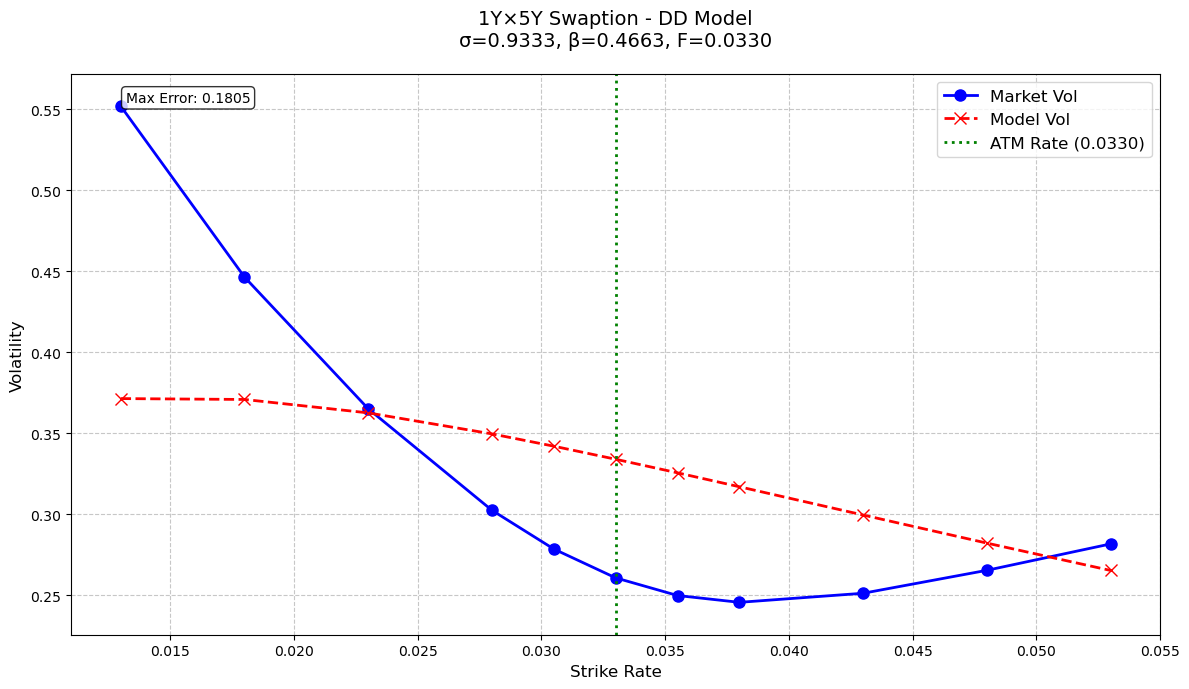

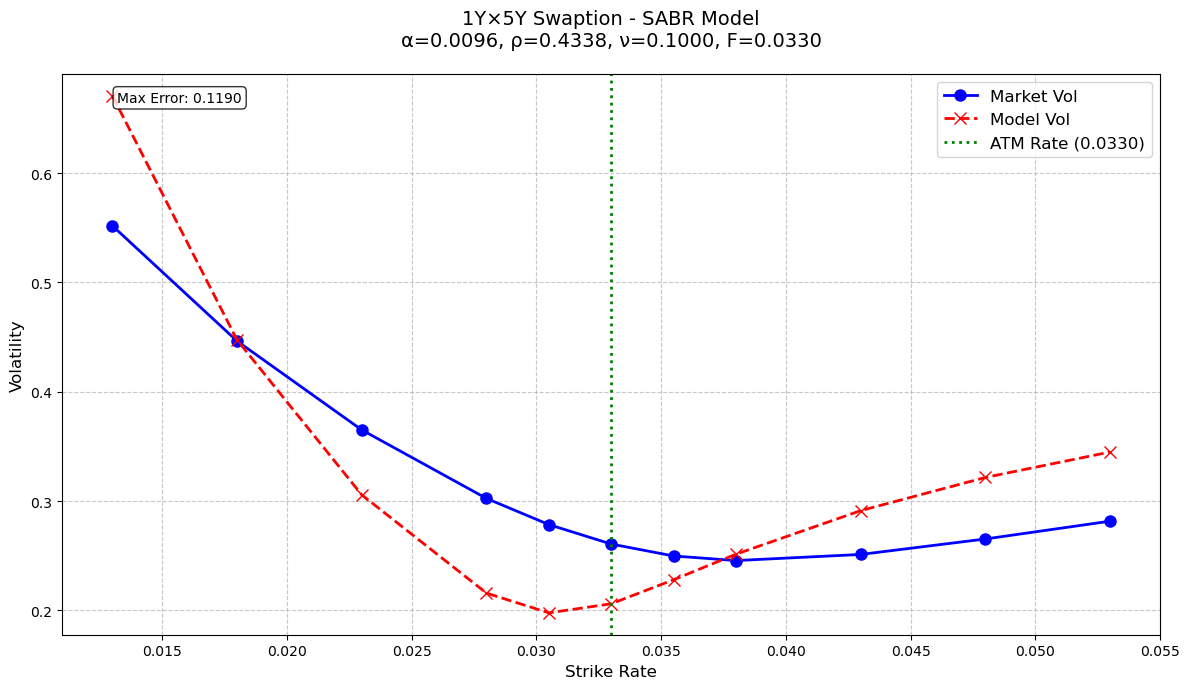

skip 2Y×10Y: missing the DD parameter
Processing 5Y×10Y:
DD parameter: σ = 0.9056, β = 0.8000
SABR parameter: α = 0.0119, ρ = 0.8254, ν = 0.1208


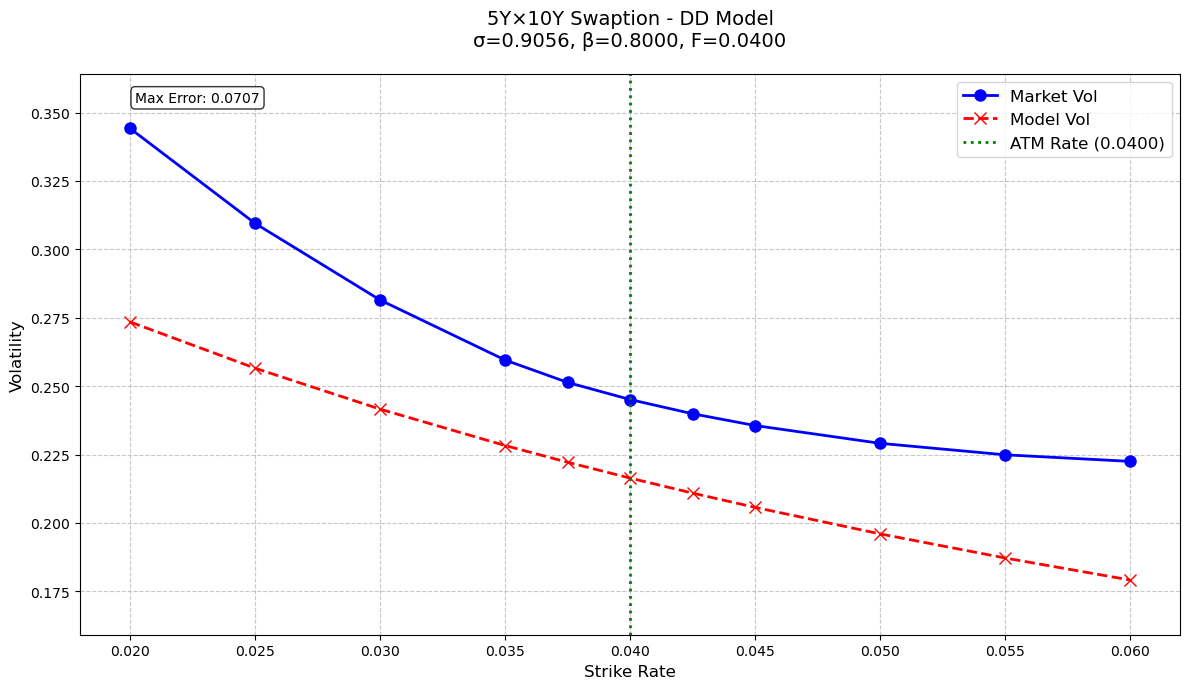

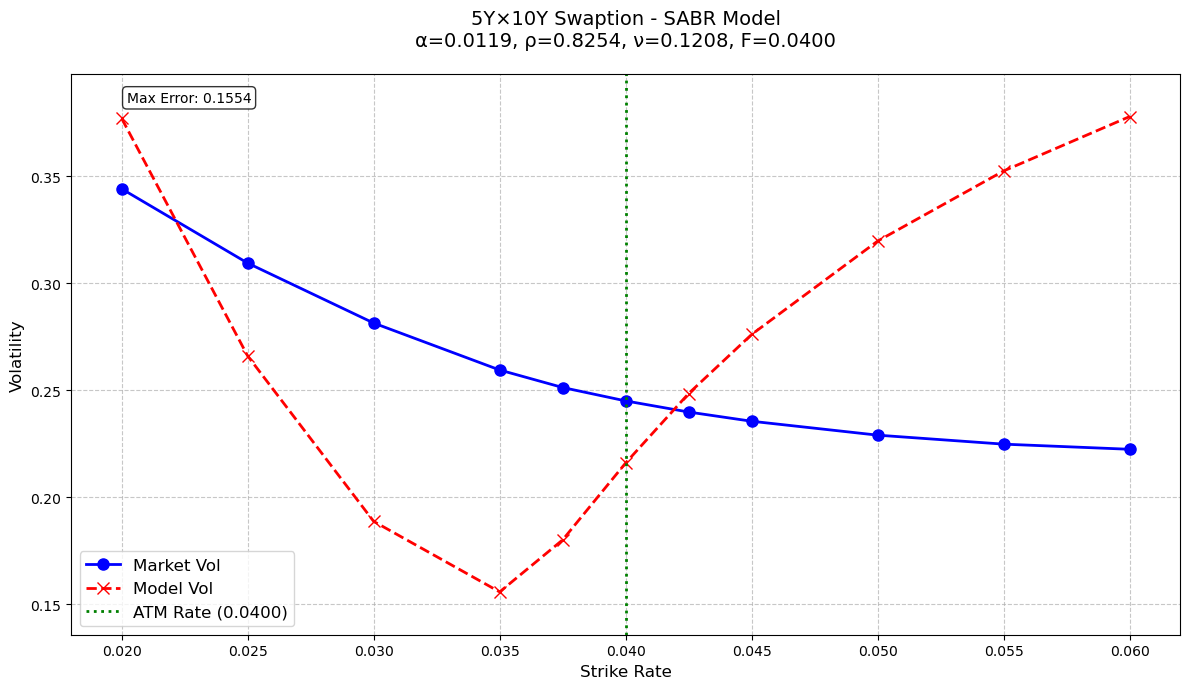

In [28]:
for expiry, tenor in [(1,5), (2,10), (5,10)]:
    try:
        # Check whether the data exists
        if (expiry, tenor) not in dd_params.index:
            print(f"skip {expiry}Y×{tenor}Y: missing the DD parameter")
            continue
        if (expiry, tenor) not in sabr_params.index:
            print(f"skip {expiry}Y×{tenor}Y: missing the SABR parameter")
            continue
            
        # obtain the parameter
        dd_p = dd_params.loc[(expiry, tenor)]
        sabr_p = sabr_params.loc[(expiry, tenor)]
        
        # Print debugging information
        print(f"Processing {expiry}Y×{tenor}Y:")
        print(f"DD parameter: σ = {dd_p['Sigma']:.4f}, β = {dd_p['Beta']:.4f}")
        print(f"SABR parameter: α = {sabr_p['Alpha']:.4f}, ρ = {sabr_p['Rho']:.4f}, ν = {sabr_p['Nu']:.4f}")
        
        plot_calibration_results(expiry, tenor, 'dd', 
                               [dd_p['Sigma'], dd_p['Beta']], 
                               swaption_vols, forward_rates)
        
        plot_calibration_results(expiry, tenor, 'sabr',
                               [sabr_p['Alpha'], sabr_p['Rho'], sabr_p['Nu']],
                               swaption_vols, forward_rates)
        
    except Exception as e:
        print(f"dispose the error happened at {expiry}Y×{tenor}Y: {str(e)}")
        continue  # Proceed to the next deadline